In [1]:
import anndata
from anndata import AnnData
import numpy as np
import matplotlib.pyplot as plt
from typing import *
import pandas as pd
import os
import scanpy as sc
import matplotlib as mpl
import seaborn as sns
import scipy as sp

In [2]:
import rpy2.rinterface_lib.callbacks
import logging
from rpy2.robjects import pandas2ri
import anndata2ri

# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

In [3]:
%R library(scran)

'scran','scuttle','SingleCe...,...,'datasets','methods','base'


In [4]:
tmp_output = "/home/icb/dominik.klein/data"

In [5]:
df_summary = pd.read_csv("/storage/groups/ml01/datasets/raw/2022-03-14_lickert_endocrinogenesis_10x_multiome/outs/summary.csv")

In [6]:
graph_clusters = pd.read_csv("/storage/groups/ml01/datasets/raw/2022-03-14_lickert_endocrinogenesis_10x_multiome/outs/analysis/clustering/atac/graphclust/clusters.csv")
graph_clusters.set_index("Barcode", inplace=True)

In [7]:
kmeans_2_clusters = pd.read_csv("/storage/groups/ml01/datasets/raw/2022-03-14_lickert_endocrinogenesis_10x_multiome/outs/analysis/clustering/atac/kmeans_2_clusters/clusters.csv")
kmeans_2_clusters.set_index("Barcode", inplace=True)
kmeans_2_clusters.rename(columns={"Cluster": "kmeans_2_clusters"}, inplace=True)

In [ ]:
adata = sc.read_10x_h5("/storage/groups/ml01/datasets/raw/2022-03-14_lickert_endocrinogenesis_10x_multiome/outs/filtered_feature_bc_matrix.h5", gex_only=False)

In [ ]:
adata.var.feature_types.unique()

In [ ]:
adata_atac = adata[:,adata.var.feature_types=="Peaks"].copy()

In [ ]:
#adata_gex = adata[:,adata.var.feature_types=="Gene Expression"].copy()

In [ ]:
del adata

In [ ]:
adata_atac

In [ ]:
#adata_gex

In [ ]:
adata_atac.obs = adata_atac.obs.merge(kmeans_2_clusters, left_index=True, right_index=True)

In [ ]:
adata_atac.obs = adata_atac.obs.merge(graph_clusters, left_index=True, right_index=True)

# GEX preprocessing

In [ ]:
# no mitochondrial genes
np.sum(adata_atac.var_names.str.startswith("MT-"))

In [ ]:
sc.pp.calculate_qc_metrics(adata_atac, inplace=True)

In [ ]:
adata_gex.var_names_make_unique()

In [15]:
#adata_gex.obs["total_counts"] = np.sum(adata_gex.X, axis=1)

In [16]:
#tmp = np.array(adata_gex.X.sum(axis=1))[:,0]

In [13]:
#adata_gex.obs["total_counts"] = tmp

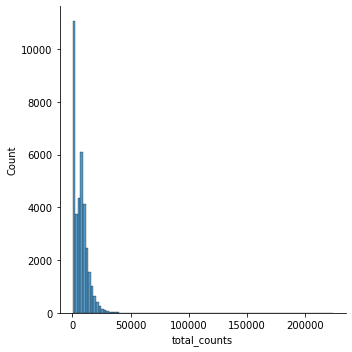

In [81]:
t1 = sns.displot(adata_gex.obs['total_counts'], bins=100, kde=False)

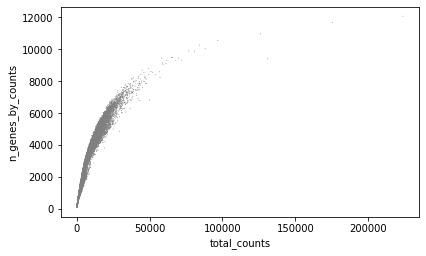

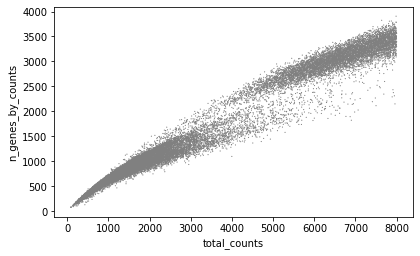

In [101]:
#Data quality summary plots
# We don't have mitochondrial genes so we needn't threshold in this step.
p1 = sc.pl.scatter(adata_gex, 'total_counts', 'n_genes_by_counts')
p2 = sc.pl.scatter(adata_gex[adata_gex.obs['total_counts']<8000], 'total_counts', 'n_genes_by_counts')

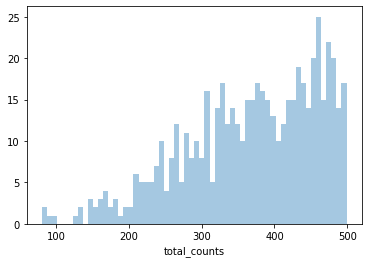

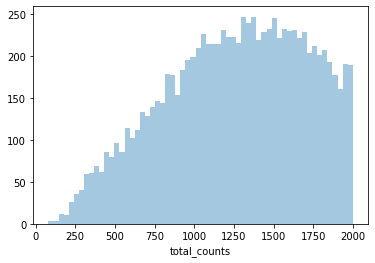

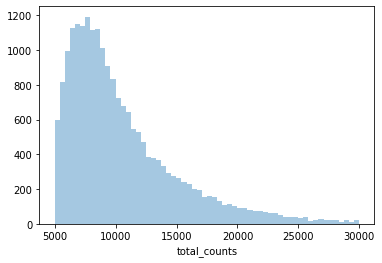

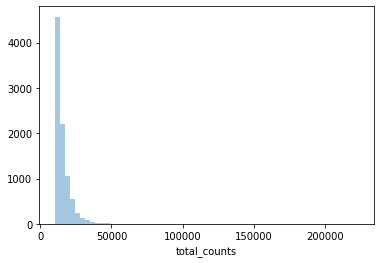

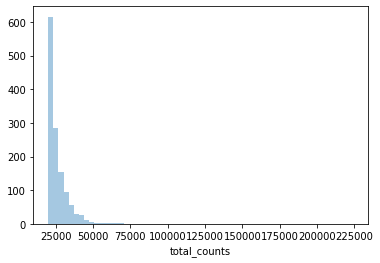

In [90]:
#Thresholding decision: counts
# Here we check the univariate distributions for low-quality outlier peaks. We especially zoom in on lower values
p3 = sns.distplot(adata_gex.obs['total_counts'][adata_gex.obs['total_counts']<500], kde=False, bins=60)
plt.show()

p4 = sns.distplot(adata_gex.obs['total_counts'][adata_gex.obs['total_counts']<2000], kde=False, bins=60)
plt.show()

p5 = sns.distplot(adata_gex.obs['total_counts'][(adata_gex.obs['total_counts']>5000) & (adata_gex.obs['total_counts']<30000)], kde=False, bins=60)
plt.show()

p6 = sns.distplot(adata_gex.obs['total_counts'][adata_gex.obs['total_counts']>10000], kde=False, bins=60)
plt.show()

p7 = sns.distplot(adata_gex.obs['total_counts'][adata_gex.obs['total_counts']>20000], kde=False, bins=60)
plt.show()

Different thresholding options:

lower bound:
- 320
- 410 (use this)


upper bound:
- 26000 (use this)
- 29000 

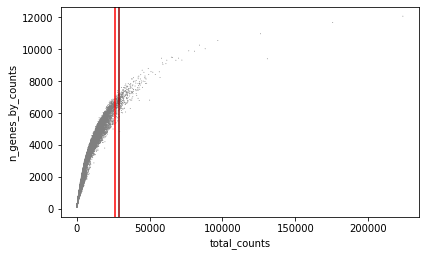

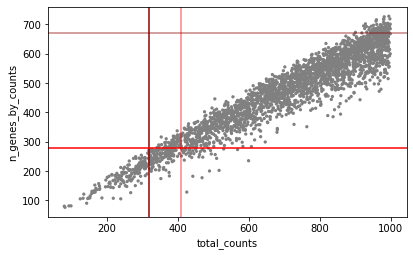

In [104]:
# Visualize the chosen thresholds jointly, before filtering out cells
counts_upper = 26000
counts_upper_alt = 29000
counts_lower = 410
counts_lower_alt = 320
genes_lower = 280 #take this one (as we don't have mitochondrial reads this threshold is not so important)
genes_lower_alt = 670

p9 = sc.pl.scatter(adata_gex, 'total_counts', 'n_genes_by_counts', show=False)
p9.axvline(x=counts_upper, color='red')
p9.axvline(x=counts_upper_alt, color='darkred')
plt.show()

count_lim = 1000
p10 = sc.pl.scatter(adata_gex[adata_gex.obs['total_counts']<count_lim], 'total_counts', 'n_genes_by_counts', show=False)
p10.axvline(counts_lower, color='red', alpha=0.5)
p10.axvline(counts_lower_alt, color='darkred')
p10.axhline(genes_lower, color='red')
p10.axhline(genes_lower_alt, color='darkred', alpha=0.5)
plt.show()

In [21]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata_gex.n_obs))

sc.pp.filter_cells(adata_gex, min_counts = 410)
print('Number of cells after min count filter: {:d}'.format(adata_gex.n_obs))

sc.pp.filter_cells(adata_gex, max_counts = 26000)
print('Number of cells after max count filter: {:d}'.format(adata_gex.n_obs))

sc.pp.filter_cells(adata_gex, min_genes = 280)
print('Number of cells after gene filter: {:d}'.format(adata_gex.n_obs))

Total number of cells: 36278
Number of cells after min count filter: 35940
Number of cells after max count filter: 35493
Number of cells after gene filter: 35447


In [22]:
sc.pp.filter_genes(adata_gex, min_cells=20)
print('Number of genes after cell filter: {:d}'.format(adata_gex.n_vars))

Number of genes after cell filter: 19645


# Normalization

In [23]:
adata_pp = adata_gex.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added='groups', resolution=0.5)

2022-03-15 13:06:17.286779: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/R/lib/R/lib
2022-03-15 13:06:17.286827: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [24]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata_gex.X.T.A

In [25]:
%%R -i data_mat -i input_groups -o size_factors

#res = sizeFactors(computeSumFactors(SingleCellExperiment(list(counts=data_mat)), clusters=input_groups, min.mean=0.1))
size_factors = sizeFactors(computeSumFactors(SingleCellExperiment(list(counts=data_mat)), clusters=input_groups, min.mean=0.1))

In [26]:
del adata_pp

... storing 'feature_types' as categorical
... storing 'genome' as categorical


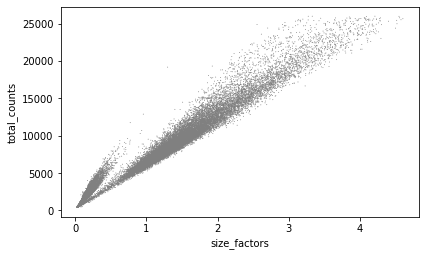

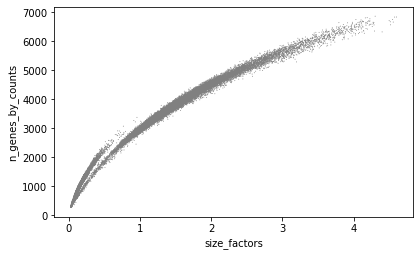

/opt/python/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


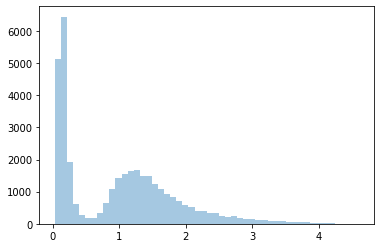

In [31]:
# Visualize the estimated size factors
adata_gex.obs['size_factors'] = size_factors

sc.pl.scatter(adata_gex, 'size_factors', 'total_counts')
sc.pl.scatter(adata_gex, 'size_factors', 'n_genes_by_counts')

sns.distplot(size_factors, bins=50, kde=False)
plt.show()

In [32]:
#Keep the count data in a counts layer
adata_gex.layers["counts"] = adata_gex.X.copy()

#Normalize adata 
adata_gex.X /= adata_gex.obs['size_factors'].values[:,None]
sc.pp.log1p(adata_gex)

#Transform back into a sparse matrix
adata_gex.X = sp.sparse.csr_matrix(adata_gex.X)

#Store the full data set in 'raw' as log-normalised data for statistical testing
adata_gex.raw = adata_gex

# HVG

In [33]:
sc.pp.highly_variable_genes(adata_gex, flavor='cell_ranger', n_top_genes=4000)
print('\n','Number of highly variable genes: {:d}'.format(np.sum(adata_gex.var['highly_variable'])))


 Number of highly variable genes: 4000


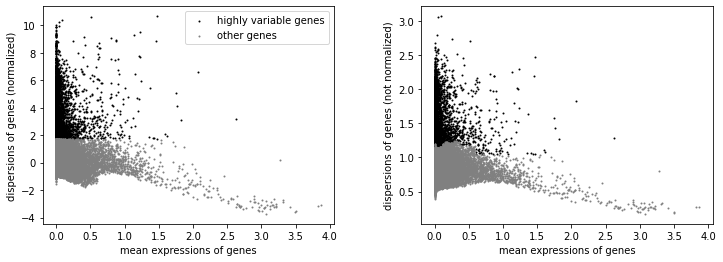

In [34]:
sc.pl.highly_variable_genes(adata_gex)

# Visualisation

In [35]:
# Calculate the visualizations
sc.pp.pca(adata_gex, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata_gex)
sc.tl.umap(adata_gex)

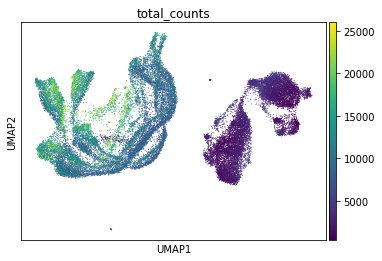

In [36]:
sc.pl.umap(adata_gex, color='total_counts')

# Clustering

In [37]:
sc.tl.leiden(adata_gex, resolution=0.3, key_added='leiden_res0.3')
sc.tl.leiden(adata_gex, resolution=0.5, key_added='leiden_res0.5')
sc.tl.leiden(adata_gex, resolution=0.8, key_added='leiden_res0.8')
sc.tl.leiden(adata_gex, resolution=1, key_added='leiden_res1')

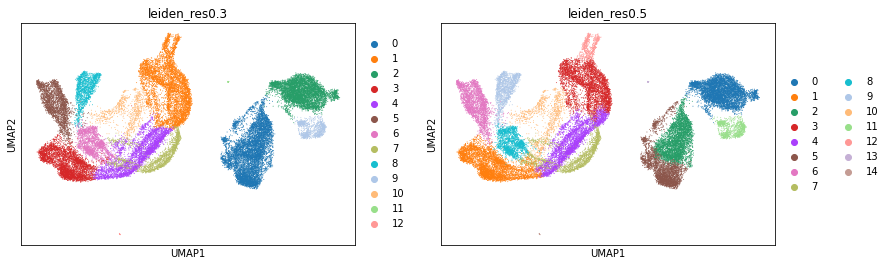

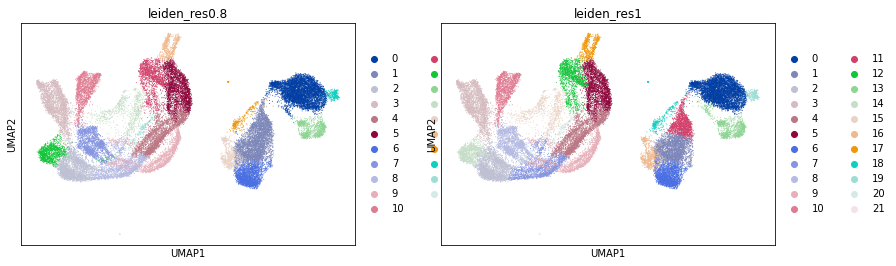

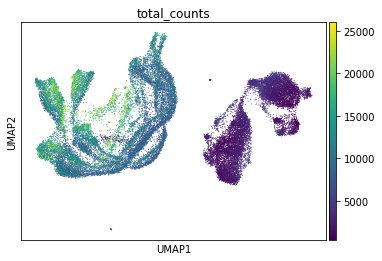

In [38]:
sc.pl.umap(adata_gex, color=['leiden_res0.3', 'leiden_res0.5'])
sc.pl.umap(adata_gex, color=['leiden_res0.8', 'leiden_res1'])
sc.pl.umap(adata_gex, color='total_counts')

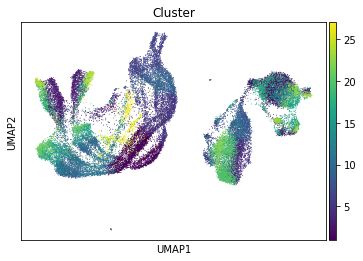

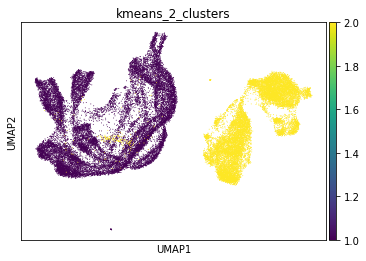

In [39]:
sc.pl.umap(adata_gex, color='Cluster')
sc.pl.umap(adata_gex, color='kmeans_2_clusters')

In [42]:
adata_gex

AnnData object with n_obs × n_vars = 35447 × 19645
    obs: 'kmeans_2_clusters', 'Cluster', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', 'n_genes', 'size_factors', 'leiden_res0.3', 'leiden_res0.5', 'leiden_res0.8', 'leiden_res1'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_res0.3_colors', 'leiden_res0.5_colors', 'leiden_res0.8_colors', 'leiden_res1_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

# Doublet detection

In [40]:
test_dat = adata_gex.copy()
test_dat.X = adata_gex.raw.X


In [44]:
sc.external.pp.scrublet(test_dat)

/opt/python/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.14
Detected doublet rate = 5.0%
Estimated detectable doublet fraction = 77.7%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 6.4%


In [45]:
adata_gex.obs['doublet_score'] = test_dat.obs['doublet_score']
adata_gex.obs['predicted_doublet'] = test_dat.obs['predicted_doublet'].astype(str)

In [46]:
del test_dat

... storing 'predicted_doublet' as categorical


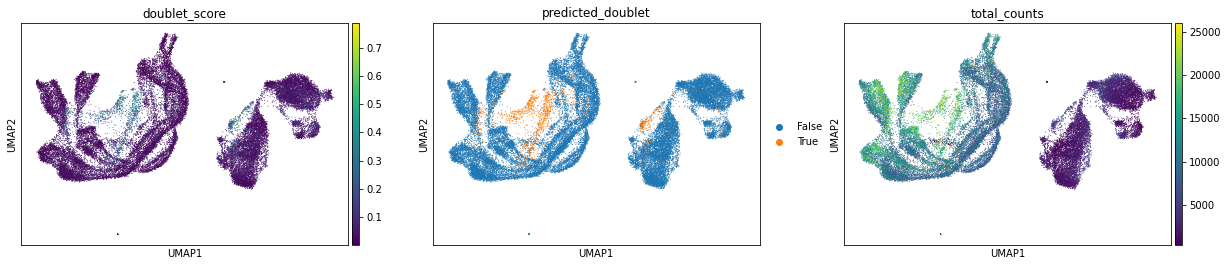

In [47]:
sc.pl.umap(adata_gex, color=['doublet_score', 'predicted_doublet', 'total_counts'])